In [1]:
import raman_rabi
from raman_rabi import rr_model
from raman_rabi import rr_io
from raman_rabi import RRDataContainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import warnings
#warnings.filterwarnings("error")

In [3]:
#import mN=+1 data
data_length = 20
testfilepath = rr_io.get_example_data_file_path('21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt')
mN1_data = RRDataContainer(testfilepath)

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest

# Using Initial Guesses are taken from from Binned Data MAP, but that doesn't really matter, if we walk long enough we get back to the same spot! This run is way to stupid short for real analysis.

In [4]:
#Estimates from Cluster MCMC
params= np.array([8.36254404e+00, 2.70752593e+01, 1.62175302e-02, 8.43378839e+00, 3.24751892e-01, 1.33240464e-01])
theta = np.concatenate( (params, skew_value_params), axis=0)
param_length = len(theta)

# run MCMC on the test data and see if it's pretty close to the original theta
guesses = theta
numdim = len(guesses)
numwalkers = 200
numsteps = 1000
np.random.seed(0)
test_samples = rr_model.laserskew_Walkers(mN1_data, guesses,0, 40, True, dataN=10,scale_factor=100*100,nwalkers=numwalkers,nsteps=numsteps)
burn_in_time = 500
samples = test_samples.chain[:,burn_in_time:,:]
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

Guess Parameters
[8.36254404e+00 2.70752593e+01 1.62175302e-02 8.43378839e+00
 3.24751892e-01 1.33240464e-01]
MCMC Parameters
[8.31676082e+00 2.70612795e+01 1.63363251e-02 8.41643588e+00
 3.25401174e-01 1.33696532e-01]

Estimated Laserskew
[0.72399672 0.75163799 0.4608927  0.6089271  0.90601965 0.78624078
 0.54033579 0.53583129 0.85667485 0.92424241 0.72481573 0.75696151
 0.72788697 0.81040131 0.67915643 0.59193284 1.         0.83579032
 0.68837019 0.82739559]
MCMC Laserskew
[0.72363105 0.76176002 0.48099921 0.6307035  0.88486966 0.79022522
 0.56759265 0.55835983 0.84554591 0.91155493 0.73675062 0.78069031
 0.73391171 0.80087425 0.68657989 0.59499102 0.96457068 0.8296628
 0.68310371 0.8298174 ]



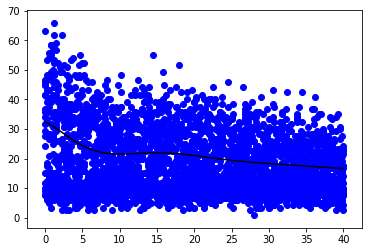

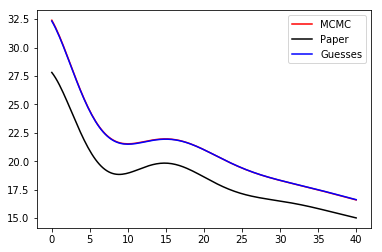

In [5]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #MOST IMPORTANT PART!!!!
#we multiply mu by the 50th percentile
#mean of laser skew

scale_factor = 100*100
N_value = 10

#Plot over unaveraged data
plt.figure()
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/N_value, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

(100000, 6)
500
100000
(200, 1000, 26)


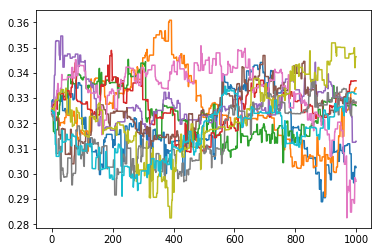

In [6]:
#Look at burn in. This isn't a very realistic set up, we start with good parameters and
#then only let the walkers walk a little while
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples.chain.shape)

param1 = 4

for iii in range(10):
    plt.plot(test_samples.chain[iii, :, param1])